# Espectros de variância, covariância e correlação

por [Afrânio](http://afrjr.weebly.com) - LMSCP - Laboratório de Modelagem, Simulação e Controle de Processos - PEQ/COPPE/UFRJ

08/2018

O objetivo deste notebook [Jupyter](http://jupyter.org/) é servir como primeira apresentação ao projeto **spectra**, destinado a implementar em Python códigos para geração de espectros de variância, covariância e correlação, de acordo com as técnicas propostas por [FEITAL E PINTO, 2015](http://onlinelibrary.wiley.com/doi/10.1002/cjce.22219/abstract). A linguagem de programação utilizada é a [Python 3.6](https://www.python.org/).

Atenção: A classe **spectra** aqui implementada está totalmente funcional, mas pode não estar em sua última versão. Para a versão mais recente, checar o módulo *spectra.py* presente no repositório https://github.com/afraeq/spectra.

In [2]:
# importando todos os módulos necessários

import os
import numpy as np
import pandas as pd
from IPython.display import HTML
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline

## 1 Definições

### 1.1 Espectros de variância

Um *espectro de variância* é um conjunto de variâncias calculado enquanto alguma variável a elas relacionadas evolui ([FEITAL E PINTO, 2015](http://onlinelibrary.wiley.com/doi/10.1002/cjce.22219/abstract)). Neste notebook em particular, o foco está no espectro de variância calculada conforme o tamanho da janela de dados utilizados no próprio cálculo da variância aumenta.

Seja um conjunto de dados $\mathbf{x}$ de tamanho $ND$. O espectro de variância de $\mathbf{x}$, dito com *janela deslizante*, é o vetor constituído dos seguintes elementos:

$$ \sigma_{TJ}^2 = \displaystyle\frac{\displaystyle\sum_{k=1}^{NJ}\displaystyle\sum_{i=k}^{k+TJ-1} \displaystyle\frac{\left(x_{i}-\bar{x}\right)^2}{TJ-1}}{NJ}$$

Sendo:

* $TJ$: o tamanho da janela, que caracteriza cada ponto do espectro;
* $NJ = ND-TJ+1$: o número de janelas em cada ponto do espectro;
* $\bar{x}$: a média na janela considerada.

O tamanho de janela máximo, nesse caso, pode ser arbitrado como $ND$.

O espectro de variância de $\mathbf{x}$, dito com *janelas independentes*, é o vetor constituído dos seguintes elementos:

$$ \sigma_{TJ}^2 = \displaystyle\frac{\displaystyle\sum_{k=1,TJ+1,2TJ+1...}^{(NJ-1)TJ +1}\displaystyle\sum_{i=k}^{k+TJ-1} \displaystyle\frac{\left(x_{i}-\bar{x}\right)^2}{TJ-1}}{NJ}$$

sendo $NJ$ nesse caso calculado pela equação $NJ = \displaystyle\frac{ND}{TJ}$. É recomendável que o tamanho de janela máximo não ultrapasse $\displaystyle\frac{ND}{2}$.

Essas duas configurações caracterizam casos extremos. Há configurações intermediárias, não consideradas por enquanto, em que as janelas apresentam diferentes graus de acoplamento.

### 1.2. Espectros de covariância

Os espectros de covariância aqui analisados são definidos da mesma forma que os espectros de variância. 

Para janela deslizante, o espectro de covariância entre dois conjuntos de dados $\mathbf{x}$ e $\mathbf{y}$ é:

$$ \sigma_{x,y,TJ}^2 = \displaystyle\frac{\displaystyle\sum_{k=1}^{NJ}\displaystyle\sum_{i=k}^{k+TJ-1} \displaystyle\frac{\left(x_{i}-\bar{x}\right)^2\left(y_{i}-\bar{y}\right)^2}{TJ-1}}{NJ}$$

Para janelas independentes, tem-se:

$$ \sigma_{x,y,TJ}^2 = \displaystyle\frac{\displaystyle\sum_{k=1,TJ+1,2TJ+1...}^{(NJ-1)TJ +1}\displaystyle\sum_{i=k}^{k+TJ-1} \displaystyle\frac{\left(x_{i}-\bar{x}\right)^2\left(y_{i}-\bar{y}\right)^2}{TJ-1}}{NJ}$$

### 1.3 Espectros de correlação

A relação entre o coeficiente de correlação de Pearson $r_{xy}$, a variância e a covariância é:

$$r_{xy} = \frac{\sigma_{xy}^2}{\sigma_x \sigma_y}$$

O coeficiente de Pearson situa-se entre -1 e 1. Quanto mais perto de 1 o valor de $|r_{xy}|$ se encontra, maior é o grau em que os dados $x$ e $y$ variam juntos.

### 1.4 Espectros de variância multidimensional

O espectro de variância multidimensional inspira-se na famosa técnica [PCA (*principal component analysis*)](https://pt.wikipedia.org/wiki/An%C3%A1lise_de_componentes_principais). Segue um sumário dos principais fundamentos do PCA:

* basicamente, a técnica realiza uma transformação de coordenadas em uma matriz de dados de modo que as novas variáveis resultantes sejam ortogonais e estejam ordenadas em ordem crescente de variância;

* as novas variáveis ortogonais criadas são chamadas de componentes principais;

* os primeiros componentes principais são os mais importantes e carregam a maior parte da informação relevante de um conjunto de dados. Os últimos componentes em geral possuem informação de ruído e podem ser descartados em uma análise;

* para aplicação da técnica, um dos métodos possíveis consiste em realizar uma [decomposição em valores singulares](https://pt.wikipedia.org/wiki/Decomposi%C3%A7%C3%A3o_em_valores_singulares) na matriz de covariância $\mathbf{M}$ dos dados. Os componentes principais são os vetores singulares à direita de $\textbf{M}$ e a variância explicada por cada um desses componentes são os valores singulares de $\textbf{M}$.

No espectro multidimensional, aplica-se a decomposição SVD na matriz de covariâncias de cada janela. Pode-se traçar assim os espectros dos valores singulares obtidos da decomposição, interpretados como as variâncias explicadas por cada um dos componentes principais. Cada curva do espectro multidimensional, portanto, diz respeito à variância explicada por um dos componentes principais.

## 2 Implementação - classe spectra

Foi implementada uma classe em Python, denominada **spectra**, para o cálculo dos espectros de variância, covariância e correlação. A classe **spectra** é constituída dos seguintes métodos:

* **\__init__**: construtor da classe, que aceita como argumento os dados a serem analisados, no formato de uma matriz com as observações nas linhas e as variáveis nas colunas;
* **calc_Var_Spectra**: cálculo dos espectros de variância de cada uma das variáveis;
* **calc_Cov_Spectra**: cálculo dos espectros de covariância e correlação de todas as possíveis combinações de variáveis;
* **calc_Multi_Var_Spectra**: cálculo do espectro de variância multidimensional de todo o conjunto de dados;
* **plot_Var_Spectra**: traçado dos espectros de variância;
* **plot_Cov_Spectra**: traçado dos espectros de covariância e correlação;
* **plot_Multi_Var_Spectra**: traçado do espectro de variância multidimensional.

Segue o código da classe:

In [12]:
class spectra (object):

    #########################
    
    def __init__ (self,data):
               
        data = np.asarray(data)
            
        if data.ndim==1:
            self.data = data[:,np.newaxis]
        elif data.ndim==2:
                self.data = data
        else:
            raise ValueError('Entry must have 1 or 2 dimensions!')
        
        self.var_spctr   = {}
        self.cov_spctr   = {}
        self.corr_spctr  = {}
        self.m_var_spctr = {}
        
        kinds = ['sliding','independent']
        
        for kind in kinds:       
            self.var_spctr   [kind] = {}
            self.cov_spctr   [kind] = {}
            self.corr_spctr  [kind] = {}
            self.m_var_spctr [kind] = {}

        self.spctr_size = {}            
        self.spctr_size['sliding']     = self.data.shape[0]+1
        self.spctr_size['independent'] = int(self.data.shape[0]/2+1)
        
        # https://stackoverflow.com/questions/39232790
        self.idx = {}
        self.idx['sliding'] =     lambda WS: (np.arange(self.data.shape[0]-WS+1)[:,None] + 
                                              np.arange(WS))
        self.idx['independent'] = lambda WS: (WS*np.arange(int(self.data.shape[0]/WS))[:,None] + 
                                              np.arange(WS))

    #########################
                
    def calc_Var_Spectra (self,kind='sliding'):
                
        spctr_size = self.spctr_size[kind]
        idx = self.idx[kind]
                        
        var_spctr_mean = np.zeros((spctr_size,self.data.shape[1]))
        var_spctr_median = np.zeros((spctr_size,self.data.shape[1]))
        
        for WS in range(2,spctr_size):
            win = self.data[idx(WS)]
            var = np.var(win,ddof=1,axis=1)
            var_spctr_mean[WS,:]   = np.mean(var,axis=0)
            var_spctr_median[WS,:] = np.median(var,axis=0)
                        
        self.var_spctr[kind]['mean'] =   var_spctr_mean                                             
        self.var_spctr[kind]['median'] = var_spctr_median

    ################################################ 
    
    def calc_Cov_Spectra (self, kind='sliding'):
        
        spctr_size = self.spctr_size[kind]
        idx = self.idx[kind]
        
        cov_spctr_mean  = np.zeros((spctr_size,self.data.shape[1],self.data.shape[1]))
        corr_spctr_mean = np.zeros((spctr_size,self.data.shape[1],self.data.shape[1]))
                
        # https://stackoverflow.com/questions/26089893
        # https://stackoverflow.com/questions/40394775
        
        for WS in range(2,spctr_size):  
            win = self.data[idx(WS)]
            m1 = win - win.sum(axis=1,keepdims=True)/win.shape[1]
            Sxx = np.einsum('ijk,ijl->ikl',m1,m1)/(win.shape[1] - 1)
            Sxx_mean = np.einsum('ijk->jk',Sxx)/win.shape[0]
            cov_spctr_mean[WS,:,:] = Sxx_mean
            Dinv = np.linalg.inv(np.diag(np.sqrt(np.diag(Sxx_mean))))
            corr_spctr_mean[WS,:,:] = Dinv@Sxx_mean@Dinv
            
        self.cov_spctr[kind]['mean']  = cov_spctr_mean
        self.corr_spctr[kind]['mean'] = corr_spctr_mean

    #########################   
    
    def calc_Multi_Var_Spectra (self, kind='sliding'):
        
        from sklearn.preprocessing import scale
        data = scale(self.data)

        spctr_size = self.spctr_size[kind]
        idx = self.idx[kind]
        
        m_var_spctr_mean = np.zeros((spctr_size,data.shape[1]))
                
        for WS in range(data.shape[1],spctr_size):  
            win = data[idx(WS)]
            m1 = win - win.sum(axis=1,keepdims=True)/win.shape[1]
            Sxx = np.einsum('ijk,ijl->ikl',m1,m1)/(win.shape[1] - 1)
            Sxx_mean = np.einsum('ijk->jk',Sxx)/win.shape[0]
            _, L, _ = np.linalg.svd(Sxx_mean)
            m_var_spctr_mean[WS,:] = L
            
        self.m_var_spctr[kind]['mean'] = m_var_spctr_mean
        
    #########################   

    def plot_Var_Spectra(self,i=None,ax=None,mean_or_median='mean'):
        
        if i==None:
            i= np.arange(self.data.shape[1])
        if ax == None:
            ax = plt.gca() 
        if self.var_spctr['sliding']:
            ax.set_prop_cycle(None)
            pd.DataFrame(self.var_spctr['sliding'][mean_or_median][:,i]).plot(ax=ax)
        if self.var_spctr['independent']:
            ax.set_prop_cycle(None)
            pd.DataFrame(self.var_spctr['independent'][mean_or_median][:,i]).plot(ax=ax,
                                                                                  linestyle='',
                                                                                  marker='.')
        ax.set_xlabel('Window size')
        ax.set_ylabel('$\sigma^2$')
        ax.legend_.remove()
        ax.margins(0);
        
    ######################### 
    
    def plot_Cov_Spectra(self,i,j,ax=None,mean_or_median='mean',corr_or_cov='corr'):

        if ax == None:
            ax = plt.gca()        
            
        if corr_or_cov == 'corr':
            spctr = self.corr_spctr
            ylabel='$r_{ij}$'
        elif corr_or_cov == 'cov':
            spctr = self.cov_spctr
            ylabel='$\sigma_{ij}^2$'    
            
        if spctr['sliding']:
            ax.set_prop_cycle(None)
            pd.DataFrame(spctr['sliding'][mean_or_median][:,i,j]).plot(ax=ax);
        if spctr['independent']:
            ax.set_prop_cycle(None)
            pd.DataFrame(spctr['independent'][mean_or_median][:,i,j]).plot(ax=ax,
                                                                           linestyle='',
                                                                           marker='.')
        ax.set_xlabel('Window size')
        ax.set_ylabel(ylabel)
        ax.legend_.remove()
        ax.margins(0);
        
    ######################### 
    
    def plot_Multi_Var_Spectra(self,ax=None,mean_or_median='mean'):
        
        if ax == None:
            ax = plt.gca() 
        
        if self.m_var_spctr['sliding']:
            ax.set_prop_cycle(None)
            pd.DataFrame(self.m_var_spctr['sliding'][mean_or_median]).plot(ax=ax)
        if self.m_var_spctr['independent']:
            ax.set_prop_cycle(None)
            pd.DataFrame(self.m_var_spctr['independent'][mean_or_median]).plot(ax=ax,linestyle='',marker='.')
        ax.set_xlabel('Window size')
        ax.set_ylabel('$\lambda_i$')
        ax.legend_.remove()
        ax.margins(0);

É importante destacar que as funções de plotagem estão disponíveis por conveniência; para plotar os dados de forma mais livre e elaborada, sempre pode-se acessar os objetos **var_spctr**, **cov_spctr**, **corr_spctr** e **m_var_spctr**.

## 3 Exemplos

### 3.1 Espectros de variância

#### 3.1.1 Exemplo 1

Para ilustrar o cálculo de um espectro de variância, [FEITAL E PINTO (2015)](http://onlinelibrary.wiley.com/doi/10.1002/cjce.22219/abstract) utilizam um sinal periódico simulado, dado pela função $y = \sin(t/4)$:

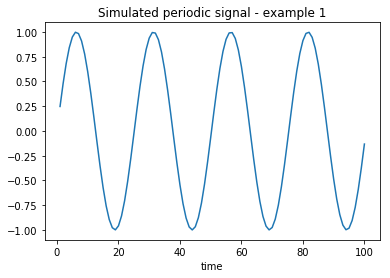

In [50]:
t1 = np.arange(1,101)
sinal1 = np.sin(t1/4)

plt.plot(t1,sinal1)
plt.title('Simulated periodic signal - example 1')
plt.xlabel('time');

Devido a abordagem de programação orientada a objetos aqui utilizada, o cálculo e plotagem dos espectros desse sinal constitui uma tarefa bem simples:

In [51]:
%%time

# creating example 1 instance
ex1 = spectra(sinal1)

# calculating example 1 spectrum, with sliding windows
ex1.calc_Var_Spectra('sliding')

# calculating example 1 spectrum, with independent windows
ex1.calc_Var_Spectra('independent')

CPU times: user 38.1 ms, sys: 3.29 ms, total: 41.4 ms
Wall time: 40 ms


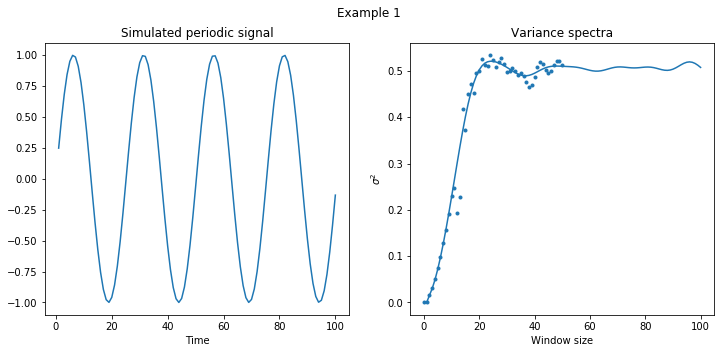

In [52]:
# plotting results

fig, ax = plt.subplots(1,2,figsize=(12,5))

ax[0].plot(t1,sinal1)
ex1.plot_Var_Spectra(ax=ax[1])

ax[0].set_xlabel('Time')

ax[0].set_title('Simulated periodic signal');
ax[1].set_title('Variance spectra');
fig.suptitle('Example 1');

A curva de janela deslizante obtida é a mesma apresentada por [FEITAL E PINTO (2015)](http://onlinelibrary.wiley.com/doi/10.1002/cjce.22219/abstract).

#### 3.1.2 Exemplo 2

De modo a analisar o efeito do aumento do número de dados amostrados, mais um teste foi realizado com o mesmo sinal:

In [53]:
t2 = np.arange(1,501)
sinal2 = np.sin(t/4)

In [54]:
%%time

ex2 = spectra(sinal2)

ex2.calc_Var_Spectra('sliding')
ex2.calc_Var_Spectra('independent')

CPU times: user 423 ms, sys: 45.4 ms, total: 468 ms
Wall time: 475 ms


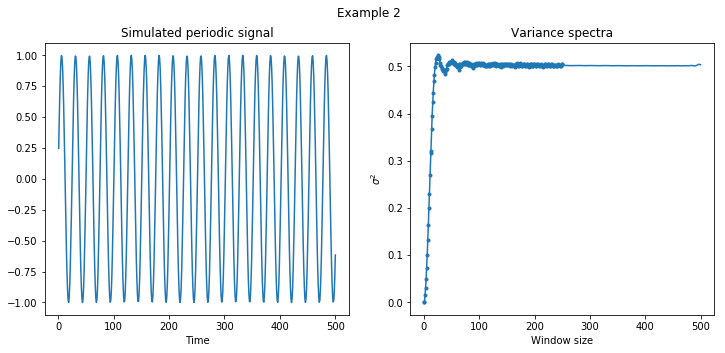

In [55]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

ax[0].plot(t2,sinal2)
ex2.plot_Var_Spectra(ax=ax[1])

ax[0].set_xlabel('Time')

ax[0].set_title('Simulated periodic signal');
ax[1].set_title('Variance spectra');
fig.suptitle('Example 2');

Percebe-se que o espectro com janelas independentes se torna menos disperso. Esse não é um efeito meramente visual, como pode-se notar ao se focar em uma região menor do gráfico:

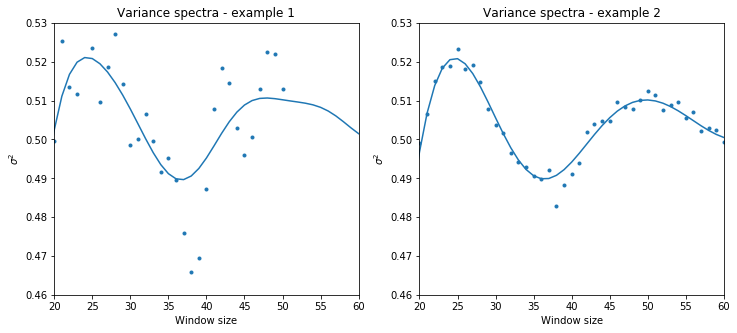

In [58]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

ex1.plot_Var_Spectra(ax=ax[0])
ax[0].axis((20,60,0.46,0.53))
ax[0].set_title('Variance spectra - example 1')

ex2.plot_Var_Spectra(ax=ax[1])
ax[1].axis((20,60,0.46,0.53))
ax[1].set_title('Variance spectra - example 2');

#### 3.1.3 - Exemplo 3

O exemplo 3 foi realizado com sinais constituídos de diferentes somas de funções senos e cossenos. A importância do exemplo reside na flutuação das variâncias que ocorre nesse tipo de sinal, efeito que surge em dados reais.

In [65]:
t3 = np.arange(-12*np.pi,12*np.pi+0.1,0.5)

sinal3 = 0

for i in range(20):
    sinal3 += np.sin((i+1)*t3/4)

In [66]:
ex3 = spectra(sinal3)

ex3.calc_Var_Spectra('sliding')
ex3.calc_Var_Spectra('independent')

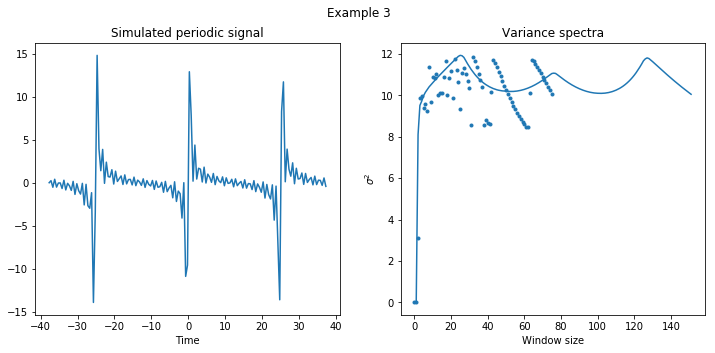

In [67]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

ax[0].plot(t3,sinal3)
ex3.plot_Var_Spectra(ax=ax[1])

ax[0].set_xlabel('Time')

ax[0].set_title('Simulated periodic signal');
ax[1].set_title('Variance spectra');
fig.suptitle('Example 3');

Como pode-se notar, as flutuações nas variâncias fazem surgir "barrigas" no espectro com janela deslizante e grandes saltos no espectro com janelas independentes.

#### 3.1.4 Exemplo 4

No exemplo 4, é avaliado o efeito da adição de sucessivos termos à soma de senos utilizada no exemplo 3. Para tal, foi gerada uma animação em vídeo:

In [71]:
t4 = np.arange(-12*np.pi,12*np.pi+0.1,0.5)

fig, axarr = plt.subplots(1,2,figsize=(12,6))

plt.close()

sinal4 = []
ex4 = []
soma = 0

for i in range(200):
    
    soma += np.sin((i+1)*t/4)
    sinal4.append(soma.copy()) 
    ex4.append(spectra(soma))
    ex4[i].calc_Var_Spectra('sliding')
    ex4[i].calc_Var_Spectra('independent')

def animate(i):

    axarr[0].clear()
    axarr[1].clear()
    axarr[0].plot(t,sinal4[i])
    ex4[i].plot_Var_Spectra(ax=axarr[1])
    axarr[0].set_xlabel('Time')
    axarr[0].set_title('Simulated periodic signal')
    axarr[1].set_title('Variance spectra')
    fig.suptitle('Example 4')
    
    return (axarr[0],axarr[1])

anim4 = animation.FuncAnimation(fig, animate, frames=200, interval=300, blit=False)

In [72]:
HTML(anim4.to_html5_video())

### 3.2 Espectros de covariância e correlação

Ao contrário do espectro de variância, os demais tipos de espectros não estão presentes [no artigo de Feital e Pinto]((http://onlinelibrary.wiley.com/doi/10.1002/cjce.22219/abstract)), que introduziu o assunto. Portanto, não há no caso da covariância e correlação uma referência de sinal simulado para ser utilizada com fins de comparação. Portanto, neste texto foram analisados exemplos de sinais em que se consegue prever o comportamento dos espectros.

#### 3.2.1 Exemplo 5

O exemplo 5 foi realizado com dois sinais lineares e totalmente correlacionados: [0,1,2,...100] e [0,3,6,...,300].

In [139]:
%%time

t5 = np.arange(1,301)
sinal5_1 = t5
sinal5_2 = 3*t5

ex5 = spectra(np.array([sinal5_1,sinal5_2]).T)

ex5.calc_Cov_Spectra('sliding')
ex5.calc_Cov_Spectra('independent')

CPU times: user 622 ms, sys: 5.78 ms, total: 627 ms
Wall time: 628 ms


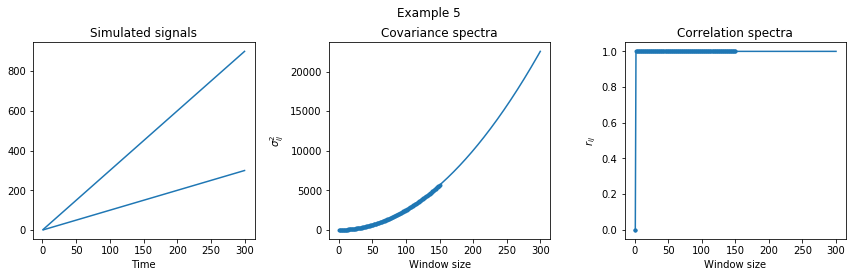

In [140]:
fig, ax = plt.subplots(1,3,figsize=(12,4))

fig.suptitle('Example 5')

ax[0].plot(t5,sinal5_1)
ax[0].set_prop_cycle(None)
ax[0].plot(t5,sinal5_2)

ex5.plot_Cov_Spectra(0,1,ax=ax[1],corr_or_cov='cov')
ex5.plot_Cov_Spectra(0,1,ax=ax[2],corr_or_cov='corr')

ax[0].set_xlabel('Time')
ax[0].set_title('Simulated signals')
ax[1].set_title('Covariance spectra')
ax[2].set_title('Correlation spectra')


fig.tight_layout(rect=[0, 0.03, 1, 0.95])

Os resultados estão de acordo com o esperado, já que a covariância aumenta com o tamanho da janela (comportamento condizente com o caráter crescente de ambos os sinais) e a correlação é constante e vale 1.

#### 3.2.2 Exemplo 6

No Exemplo 6, são adicionadas flutuações aleatórias aos sinais do Exemplo 5:

In [149]:
%%time

t6 = np.arange(1,301)
sinal6_1 = t6 +100*np.random.rand(t6.size)
sinal6_2 = 3*t6 +100*np.random.rand(t6.size)

ex6 = spectra(np.array([sinal6_1,sinal6_2]).T)

ex6.calc_Cov_Spectra('sliding')
ex6.calc_Cov_Spectra('independent')

CPU times: user 619 ms, sys: 7.3 ms, total: 626 ms
Wall time: 629 ms


Espera-se que o espectro de covariância tenha o mesmo aspecto que o do exemplo 5 (já que a tendência crescente de ambos os sinais é a mesma). O espectro de correlação, no entanto, deve ser bem diferente, já que o efeito da flutuação em janelas pequenas faz com que a correlação seja significativamente baixa.

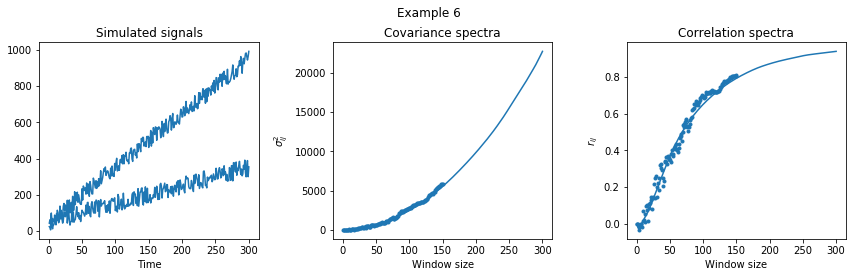

In [150]:
fig, ax = plt.subplots(1,3,figsize=(12,4))

fig.suptitle('Example 6')

ax[0].plot(t6,sinal6_1)
ax[0].set_prop_cycle(None)
ax[0].plot(t6,sinal6_2)

ex6.plot_Cov_Spectra(0,1,ax=ax[1],corr_or_cov='cov')
ex6.plot_Cov_Spectra(0,1,ax=ax[2],corr_or_cov='corr')

ax[0].set_xlabel('Time')
ax[0].set_title('Simulated signals')
ax[1].set_title('Covariance spectra')
ax[2].set_title('Correlation spectra')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

#### 3.2.3 Exemplo 7

Como sétimo exemplo, foram analisados dois sinais periódicos seno e cosseno, cuja covariância deve ser nula de acordo com um [resultado clássico da estatística](https://stats.stackexchange.com/questions/224098/correlation-between-sine-and-cosine).

In [158]:
t7 = np.arange(1,101)

sinal7_1 = np.sin(t7/4)
sinal7_2 = np.cos(t7/4)

ex7 = spectra(np.array([sinal7_1,sinal7_2]).T)

ex7.calc_Cov_Spectra('sliding')
ex7.calc_Cov_Spectra('independent')

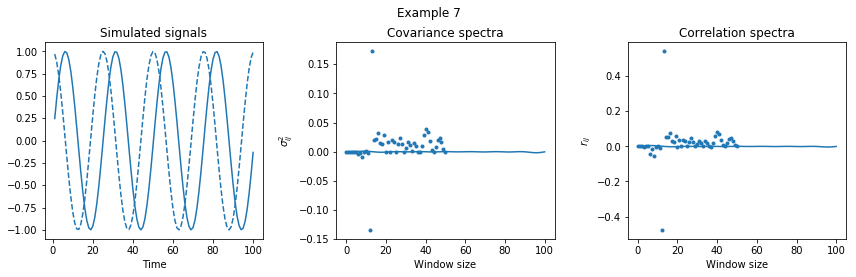

In [160]:
fig, ax = plt.subplots(1,3,figsize=(12,4))

fig.suptitle('Example 7')

ax[0].plot(t7,sinal7_1)
ax[0].set_prop_cycle(None)
ax[0].plot(t7,sinal7_2,'--')

ex7.plot_Cov_Spectra(0,1,ax=ax[1],corr_or_cov='cov')
ex7.plot_Cov_Spectra(0,1,ax=ax[2],corr_or_cov='corr')

ax[0].set_xlabel('Time')
ax[0].set_title('Simulated signals')
ax[1].set_title('Covariance spectra')
ax[2].set_title('Correlation spectra')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

É curioso notar que, no caso de janelas independentes grandes, os valores de covariância e correlação não flutuam em torno de zero com média zero, mas se mantém predominantemente positivos.

#### 3.2.4 - Exemplo 8

Neste exemplo, o objetivo é analisar o efeito do deslocamento entre dois sinais periódicos em seus espectros de covariância e correlação. Para isso, uma animação em vídeo foi gerada.

In [166]:
t8 = np.arange(1,51)

sinal8_1 = np.sin(t8/4)
sinal8_2 = []
ex8 = []

for i in range(128):
    
    sinal8_2.append(np.cos(t8/4+i*(np.pi/64)))
    ex8.append(spectra(np.array([sinal8_1, sinal8_2[i]]).T))
    ex8[i].calc_Cov_Spectra('sliding')
    ex8[i].calc_Cov_Spectra('independent')

fig, axarr = plt.subplots(1,3,figsize=(13,6))
plt.close()

def animate(i):
    
    axarr[0].clear()
    axarr[0].set_title('Simulated signals')
    axarr[0].set_xlabel('t')
    axarr[1].clear()
    axarr[1].set_title('Covariance spectra')
    axarr[2].clear()
    axarr[2].set_title('Correlation spectra')
    axarr[0].plot(t8,sinal8_1)
    axarr[0].set_prop_cycle(None)
    axarr[0].plot(t8,sinal8_2[i])
    ex8[i].plot_Cov_Spectra(0,1,ax=axarr[1],corr_or_cov='cov')
    ex8[i].plot_Cov_Spectra(0,1,ax=axarr[2],corr_or_cov='corr')
    axarr[0].set_xlim(0,50)
    axarr[0].set_ylim(-1,1)
    axarr[1].set_xlim(0,50)
    axarr[1].set_ylim(-0.75,0.75)
    axarr[2].set_xlim(0,50)
    axarr[2].set_ylim(-1,1)
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    fig.suptitle('Example 8')

    return axarr

anim8 = animation.FuncAnimation(fig, animate,frames=128, interval=200, blit=False)

In [167]:
HTML(anim8.to_html5_video())

Este exemplo é relevante para a análise de processos, já que em aplicações reais pode haver interesse em entender como a defasagem de sinais afeta os espectros de covariância e correlação entre eles. 

Em particular, neste caso, é interessante notar a dinâmica da dispersão dos pontos de janelas independentes em relação aos de janela deslizante.

### 3.3 Espectros de variância multidimensional

#### 3.3.1 Exemplo 9

No exemplo 9, a um conjunto de dez sinais inicialmente 100% correlacionados é adicionado um ruído de magnitude crescente. A animação a seguir ilustra o efeito do aumento da magnitude do ruído no espectro de variância multidimensional.

In [18]:
t9=np.arange(50)

sinais9 = []
ex9 = []

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(300):
    
    sinais9.append([j*t9 +np.random.randn(t9.size)*i for j in range(1,11)])
    ex9.append(spectra(np.array(sinais9[i]).T))
    ex9[i].calc_Multi_Var_Spectra('sliding')
    ex9[i].calc_Multi_Var_Spectra('independent')

fig, axarr = plt.subplots(1,2,figsize=(13,6))
plt.close()

def animate(i):
    
    axarr[0].clear()
    axarr[0].set_title('Simulated signals')
    axarr[0].set_xlabel('t')
    axarr[1].clear()
    axarr[1].set_title('Multidimensional variance spectrum')
    [axarr[0].plot(t9,sinais9[i][j],color=color_cycle[0]) for j in range(len(sinais9[i]))]
    pd.DataFrame(ex9[i].m_var_spctr['sliding']['mean']).plot(ax=axarr[1],
                                                             color=color_cycle[0])
    pd.DataFrame(ex9[i].m_var_spctr['independent']['mean']).plot(ax=axarr[1],
                                                                 linestyle='',
                                                                 marker='.',
                                                                 color=color_cycle[0])
    axarr[1].set_xlabel('Window size')
    axarr[1].set_ylabel('$\lambda_i$')
    axarr[1].legend_.remove()
    axarr[0].set_xlim(0,50)
    axarr[0].set_ylim(-400,600)
    axarr[1].set_xlim(10,50)
    axarr[1].set_ylim(0,8)
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    fig.suptitle('Example 9')

    return axarr

anim9 = animation.FuncAnimation(fig, animate,frames=128, interval=200, blit=False)

In [19]:
HTML(anim9.to_html5_video())

Percebe-se que no primeiro *frame*, apenas um componente do espectro é o suficiente para explicar toda a variabilidade do conjunto, já que os sinais são linearmente dependentes. Conforme o aumento do ruído degrada a correlação entre os sinais, a magnitude dos demais componentes aumenta.

## Referência

[Thiago Feital e José Carlos Pinto - Use of variance spectra for in-line validation of process measurements in continuous processes - The Canadian Journal of Chemical Engineering - 2015. DOI: 10.1002/cjce.22219.](http://onlinelibrary.wiley.com/doi/10.1002/cjce.22219/abstract)